# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm


## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("../data/Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

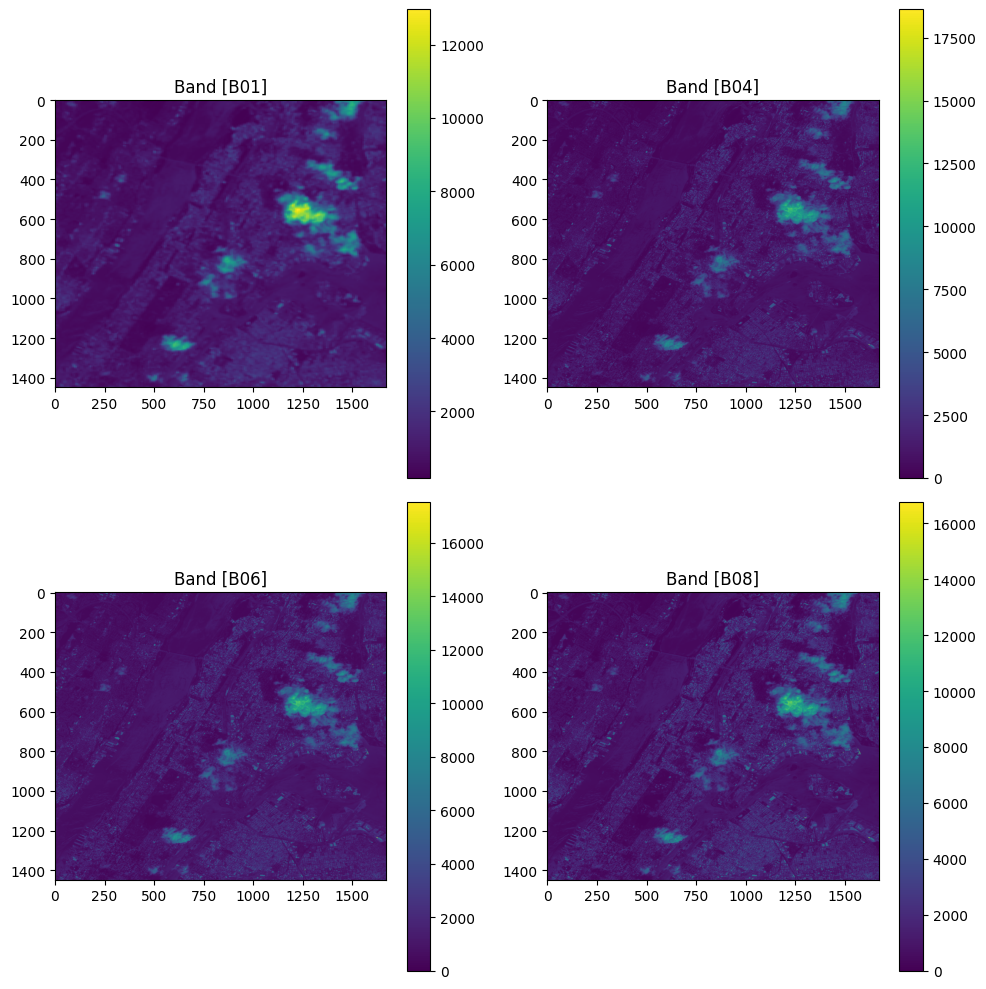

In [3]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "../data/S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [4]:
import rioxarray as rxr
import pandas as pd
import numpy as np
from tqdm import tqdm

def map_satellite_data_with_buffer(tiff_path, csv_path, buffer_radius=50):
    """
    Extracts satellite band values from a GeoTIFF based on coordinates from a csv file,
    using a buffer zone to average nearby values for each point.
    
    Parameters:
    tiff_path (str): Path to the GeoTIFF file
    csv_path (str): Path to the CSV file containing coordinates
    buffer_radius (float): Radius in meters for the buffer zone (default: 50)
    
    Returns:
    pd.DataFrame: DataFrame containing averaged band values for each input location
    """
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Calculate buffer size in pixels (10m resolution)
    buffer_pixels = int(np.ceil(buffer_radius / 10))

    # Initialize dictionary for band values
    band_values = {
        'B01': [], 'B02': [], 'B03': [], 'B04': [], 'B05': [], 
        'B06': [], 'B07': [], 'B08': [], 'B8A': [], 'B11': [], 'B12': []
    }

    # Get the affine transform from the data
    transform = data.rio.transform()
    
    # Iterate over the latitudes and longitudes
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Convert lat/lon to pixel coordinates
        row, col = ~transform * (lon, lat)
        row, col = int(row), int(col)
        
        # Calculate window bounds
        row_start = max(0, row - buffer_pixels)
        row_end = min(data.rio.width, row + buffer_pixels + 1)
        col_start = max(0, col - buffer_pixels)
        col_end = min(data.rio.height, col + buffer_pixels + 1)
        
        # Extract values for each band
        for band_idx, band_name in enumerate(['B01', 'B02', 'B03', 'B04', 'B05', 
                                            'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'], 1):
            # Get the band data for the window
            window_data = data[band_idx-1, col_start:col_end, row_start:row_end]
            
            if window_data.size > 0:
                # Create a grid of pixel coordinates
                y_indices, x_indices = np.indices(window_data.shape)
                y_coords = y_indices + col_start
                x_coords = x_indices + row_start
                
                # Calculate distances from center point
                distances = np.sqrt((x_coords - row)**2 + (y_coords - col)**2) * 10  # Convert to meters
                
                # Create mask for pixels within buffer radius
                mask = distances <= buffer_radius
                
                # Get values within buffer
                values_in_buffer = window_data.values[mask]
                
                # Calculate average if there are values in buffer
                if len(values_in_buffer) > 0:
                    avg_value = np.nanmean(values_in_buffer)
                else:
                    avg_value = data[band_idx-1, col, row].values
            else:
                # If window is empty, use the point value
                avg_value = data[band_idx-1, col, row].values
                
            band_values[band_name].append(float(avg_value))

    # Create results DataFrame
    result_df = pd.DataFrame(band_values)
    
    # Add original coordinates and buffer size info
    result_df['Latitude'] = latitudes
    result_df['Longitude'] = longitudes
    result_df['buffer_radius_m'] = buffer_radius
    
    return result_df

In [5]:
# Map the satellite data with a buffer radius of 600 meters
final_data = map_satellite_data_with_buffer('../data/S2_sample.tiff', '../data/Training_data_uhi_index_2025-02-18.csv', buffer_radius=700)

Mapping values: 100%|██████████| 11229/11229 [01:37<00:00, 115.55it/s]


In [6]:
final_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,Latitude,Longitude,buffer_radius_m
0,1136.522605,1210.372016,1371.468093,1436.461784,1680.971964,2168.692968,2343.158264,2351.114682,2443.808626,2224.580498,1843.578157,40.813107,-73.909167,700
1,1136.522605,1210.372016,1371.468093,1436.461784,1680.971964,2168.692968,2343.158264,2351.114682,2443.808626,2224.580498,1843.578157,40.813045,-73.909187,700
2,1135.378261,1210.474924,1371.624927,1436.643010,1680.397190,2168.484161,2342.897808,2351.067131,2443.632342,2223.735966,1842.141417,40.812978,-73.909215,700
3,1136.573148,1209.515839,1370.703896,1436.001886,1680.170819,2167.149418,2341.541729,2348.380928,2442.282573,2223.827295,1843.542705,40.812908,-73.909242,700
4,1138.636115,1209.805178,1371.007546,1437.027906,1680.636050,2166.124699,2340.618162,2347.806414,2441.459182,2224.051909,1844.874520,40.812845,-73.909257,700


In [7]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

In [8]:
final_data['NBDI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NBDI'] = final_data['NBDI'].replace([np.inf, -np.inf], np.nan)

In [9]:
final_data['NDWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)

In [10]:
final_data['EVI'] = 2.5 * (final_data['B08'] - final_data['B04']) / (final_data['B08'] + 6 * final_data['B04'] - 7.5 * final_data['B02'] + 1)
final_data['EVI'] = final_data['EVI'].replace([np.inf, -np.inf], np.nan)

In [11]:
L = 0.5  # Soil brightness correction factor
final_data['SAVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'] + L) * (1 + L)
final_data['SAVI'] = final_data['SAVI'].replace([np.inf, -np.inf], np.nan)

In [12]:
final_data['MSAVI'] = (2 * final_data['B08'] + 1 - np.sqrt((2 * final_data['B08'] + 1) ** 2 - 8 * (final_data['B08'] - final_data['B04']))) / 2
final_data['MSAVI'] = final_data['MSAVI'].replace([np.inf, -np.inf], np.nan)

In [13]:
final_data['WRI'] = (final_data['B03'] + final_data['B04']) / (final_data['B08'] + final_data['B11'])
final_data['WRI'] = final_data['WRI'].replace([np.inf, -np.inf], np.nan)

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [14]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [15]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,...,Latitude,Longitude,buffer_radius_m,NDVI,NBDI,NDWI,EVI,SAVI,MSAVI,WRI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1136.522605,1210.372016,1371.468093,1436.461784,1680.971964,2168.692968,...,40.813107,-73.909167,700,0.241488,-0.027654,-0.263163,1.207880,0.362184,0.388979,0.613662
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1136.522605,1210.372016,1371.468093,1436.461784,1680.971964,2168.692968,...,40.813045,-73.909187,700,0.241488,-0.027654,-0.263163,1.207880,0.362184,0.388979,0.613662
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1135.378261,1210.474924,1371.624927,1436.643010,1680.397190,2168.484161,...,40.812978,-73.909215,700,0.241419,-0.027833,-0.263101,1.207407,0.362080,0.388889,0.613855
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1136.573148,1209.515839,1370.703896,1436.001886,1680.170819,2167.149418,...,40.812908,-73.909242,700,0.241091,-0.027241,-0.262881,1.204287,0.361588,0.388463,0.613862
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1138.636115,1209.805178,1371.007546,1437.027906,1680.636050,2166.124699,...,40.812845,-73.909257,700,0.240639,-0.027069,-0.262664,1.200013,0.360911,0.387877,0.614200


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [16]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B02', 'B03', 'B04', 'B05', 
                                            'B06', 'B07', 'B08', 'B8A', 'B11', 'B12','NDVI', 'NBDI', 'NDWI', 'EVI', 'SAVI', 'MSAVI', 'WRI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,...,Latitude,Longitude,buffer_radius_m,NDVI,NBDI,NDWI,EVI,SAVI,MSAVI,WRI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1136.522605,1210.372016,1371.468093,1436.461784,1680.971964,2168.692968,...,40.813107,-73.909167,700,0.241488,-0.027654,-0.263163,1.207880,0.362184,0.388979,0.613662
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1135.378261,1210.474924,1371.624927,1436.643010,1680.397190,2168.484161,...,40.812978,-73.909215,700,0.241419,-0.027833,-0.263101,1.207407,0.362080,0.388889,0.613855
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1136.573148,1209.515839,1370.703896,1436.001886,1680.170819,2167.149418,...,40.812908,-73.909242,700,0.241091,-0.027241,-0.262881,1.204287,0.361588,0.388463,0.613862
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1138.636115,1209.805178,1371.007546,1437.027906,1680.636050,2166.124699,...,40.812845,-73.909257,700,0.240639,-0.027069,-0.262664,1.200013,0.360911,0.387877,0.614200
6,-73.909312,40.812710,24-07-2021 15:53,1.015143,1139.638392,1211.035452,1372.904573,1439.313537,1682.818903,2168.043193,...,40.812710,-73.909312,700,0.240609,-0.027480,-0.262731,1.196635,0.360866,0.387838,0.614423


In [17]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [18]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
uhi_data = uhi_data[['B01','B06','B8A','B12','NDVI','NBDI','NDWI', 'EVI', 'SAVI', 'WRI','UHI Index']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [19]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [20]:
# Basic dataset info
print("Feature names:", uhi_data.drop(columns=['UHI Index']).columns.tolist())
print("\nShape of data:", X.shape)

# Check for missing values
print("\nMissing values:\n", uhi_data.isnull().sum())

Feature names: ['B01', 'B06', 'B8A', 'B12', 'NDVI', 'NBDI', 'NDWI', 'EVI', 'SAVI', 'WRI']

Shape of data: (8991, 10)

Missing values:
 B01          0
B06          0
B8A          0
B12          0
NDVI         0
NBDI         0
NDWI         0
EVI          0
SAVI         0
WRI          0
UHI Index    0
dtype: int64


In [21]:
# Basic statistics of features
print("\nFeature statistics:\n", uhi_data.describe())


Feature statistics:
                B01          B06          B8A          B12         NDVI  \
count  8991.000000  8991.000000  8991.000000  8991.000000  8991.000000   
mean   1610.243786  2271.491549  2433.541103  1854.935154     0.179168   
std    1147.019641   917.916500   842.392720   663.329459     0.115994   
min     534.537501   949.857673   947.945294   573.858258     0.009135   
25%    1020.093378  1799.911989  1993.552007  1415.942659     0.082055   
50%    1158.935601  2042.693163  2274.812789  1738.279581     0.169007   
75%    1786.267775  2380.082320  2638.552560  2111.996390     0.236175   
max    8232.855266  7719.975802  7303.053535  4784.441488     0.616143   

              NBDI         NDWI          EVI         SAVI          WRI  \
count  8991.000000  8991.000000  8991.000000  8991.000000  8991.000000   
mean     -0.038988    -0.188898     1.196541     0.268713     0.726475   
std       0.058478     0.110677    69.075777     0.173962     0.150065   
min      -0.241

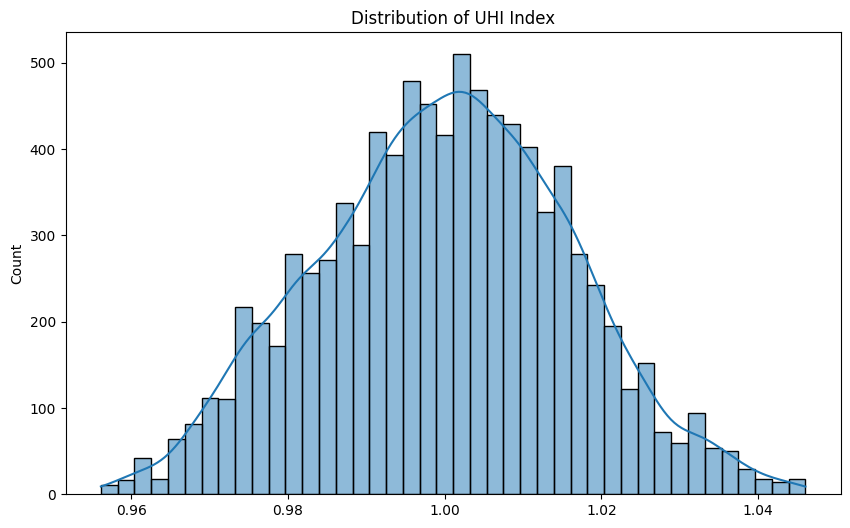

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of UHI Index')
plt.show()

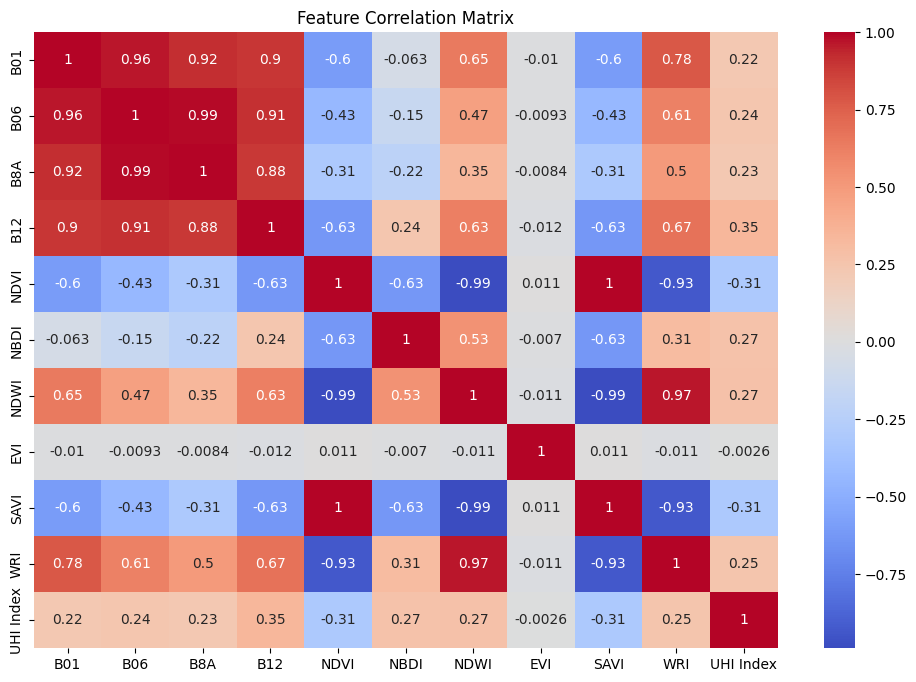

In [23]:
# Feature correlations
correlation_matrix = uhi_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Feature Scaling 

Data Characteristics:
* No missing values, which is excellent
* The target variable (UHI Index) follows a roughly normal distribution with values ranging from ~0.96 to 1.04
* Strong multicollinearity among spectral bands (B01-B8A)
* NDVI, NBDI, and NDWI show distinct correlation patterns from the spectral bands

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [24]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [25]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [26]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [27]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9874464148051113

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [28]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [29]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.912101993111995

## Random Forest Optimization

Starting advanced Random Forest optimization...

Creating interaction features...
Total features after interactions: 55

Baseline Random Forest evaluation:
Baseline - Train R²: 0.9874, Test R²: 0.9121

Performing advanced hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from random search: {'bootstrap': False, 'max_depth': None, 'max_features': 0.5, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 484}
Best CV score from random search: 0.9052
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters from grid search: {'bootstrap': False, 'max_depth': None, 'max_features': 0.5, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 434}
Best CV score from grid search: 0.9059

Optimized Random Forest performance:
Train R²: 1.0000
Test R²: 0.9243
Test RMSE: 0.0045
Overfitting Gap: 0.0757

Evaluating Random Forest with interaction features...
With inter

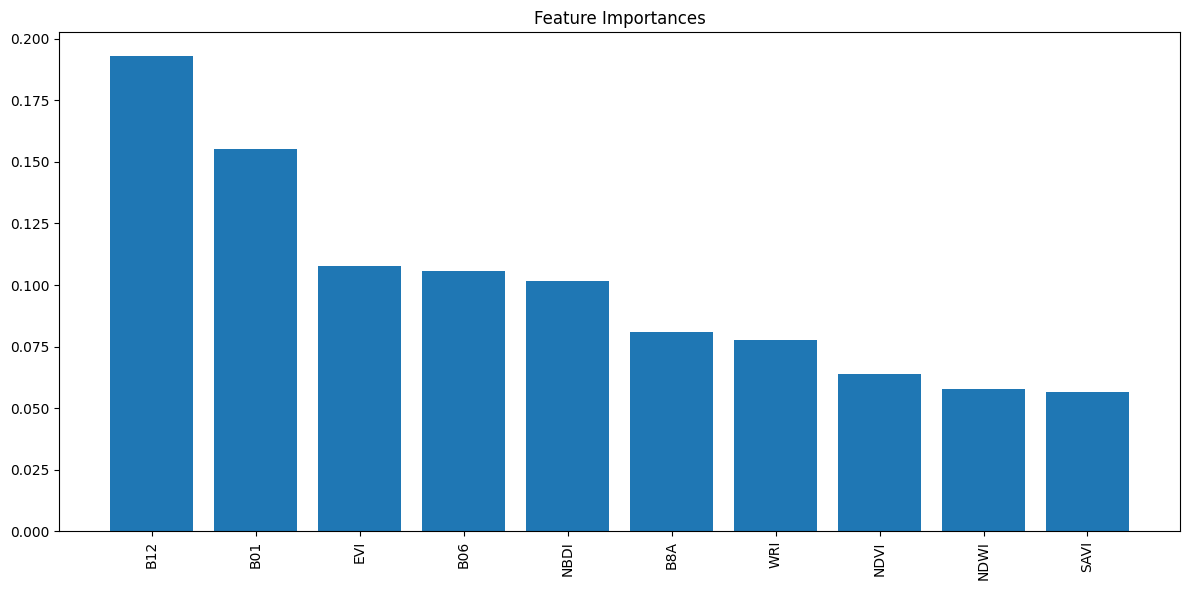

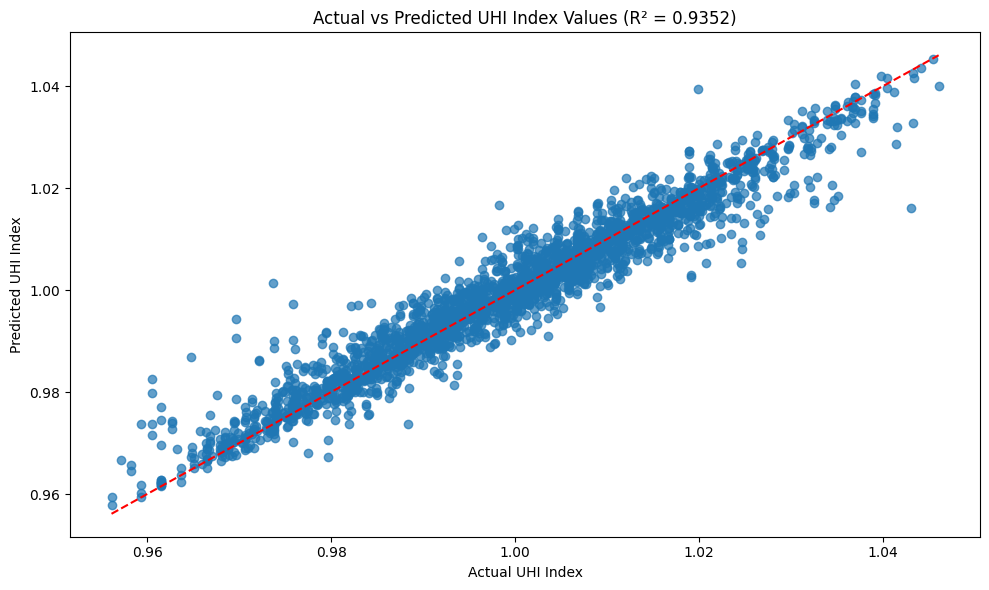

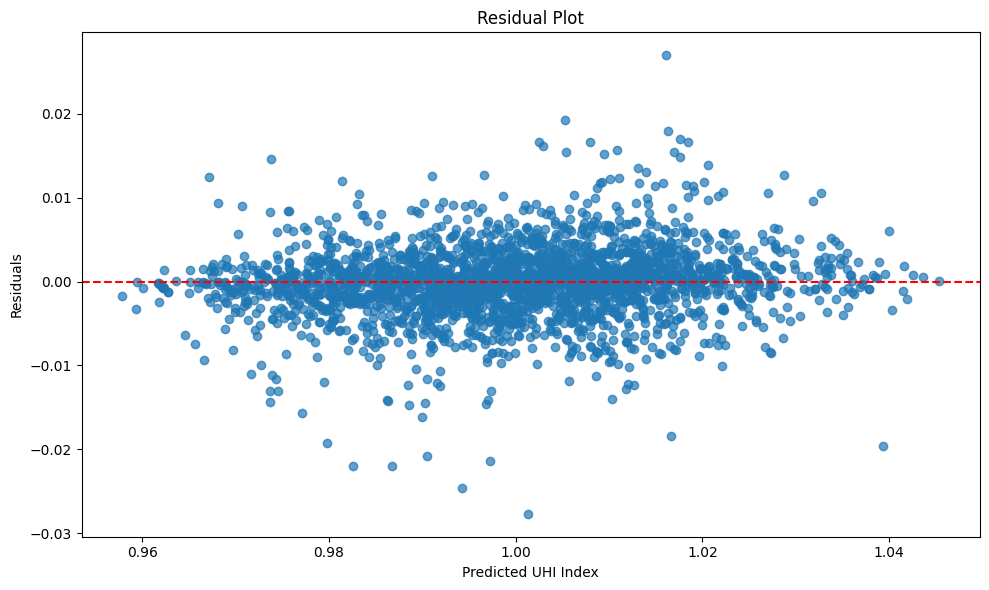

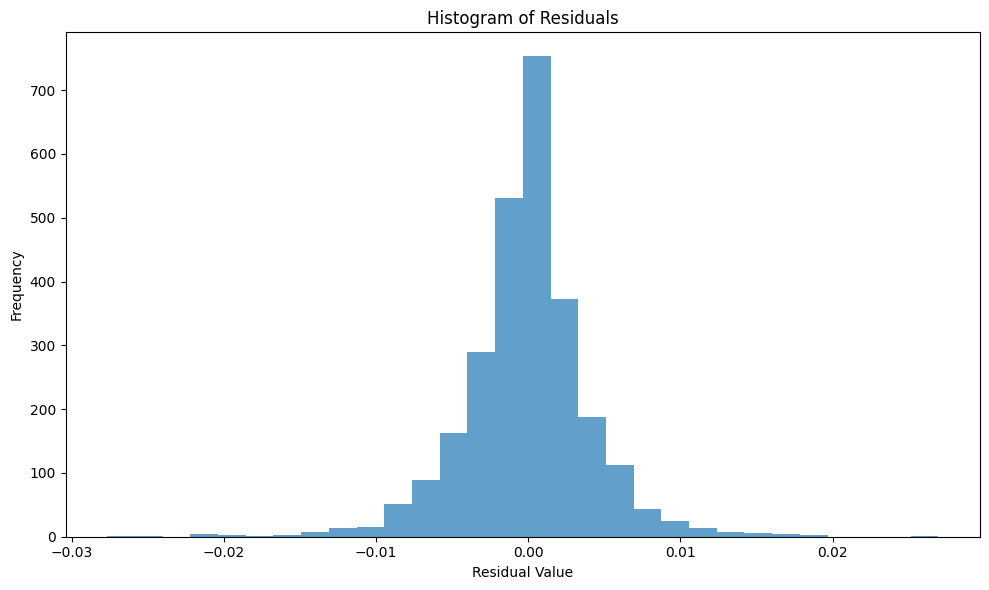

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint, uniform
import joblib

# Assuming uhi_data is already loaded
# Retaining the columns
uhi_data = uhi_data[['B01','B06','B8A','B12','NDVI','NBDI','NDWI', 'EVI', 'SAVI', 'WRI','UHI Index']]

# Split the data into features (X) and target (y)
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values
feature_names = uhi_data.drop(columns=['UHI Index']).columns

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Scale the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

print("Starting advanced Random Forest optimization...")

# 1. Feature Engineering: Create interaction features
print("\nCreating interaction features...")
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Get feature names for polynomial features
def get_poly_feature_names(feature_names, poly):
    if hasattr(poly, 'get_feature_names_out'):
        return poly.get_feature_names_out(feature_names)
    else:  # For older sklearn versions
        return poly.get_feature_names(feature_names)

poly_feature_names = get_poly_feature_names(feature_names, poly)
print(f"Total features after interactions: {len(poly_feature_names)}")

# 2. Initial evaluation with default Random Forest
print("\nBaseline Random Forest evaluation:")
baseline_rf = RandomForestRegressor(n_estimators=300, random_state=42)
baseline_rf.fit(X_train_scaled, y_train)
baseline_train_preds = baseline_rf.predict(X_train_scaled)
baseline_test_preds = baseline_rf.predict(X_test_scaled)

baseline_train_r2 = r2_score(y_train, baseline_train_preds)
baseline_test_r2 = r2_score(y_test, baseline_test_preds)
print(f"Baseline - Train R²: {baseline_train_r2:.4f}, Test R²: {baseline_test_r2:.4f}")

# 3. Advanced Hyperparameter Tuning
print("\nPerforming advanced hyperparameter tuning...")

# First do a randomized search to narrow down the parameter space
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(randint(10, 50).rvs(5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7, 0.9],
    'bootstrap': [True, False],
    'max_samples': [0.7, 0.8, 0.9, None]
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)
print(f"Best parameters from random search: {random_search.best_params_}")
print(f"Best CV score from random search: {random_search.best_score_:.4f}")

# Refine with a focused grid search around the best parameters
best_params = random_search.best_params_
grid_param = {
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth']],
    'min_samples_split': [max(2, best_params['min_samples_split'] - 2), best_params['min_samples_split'], best_params['min_samples_split'] + 2],
    'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1), best_params['min_samples_leaf'], best_params['min_samples_leaf'] + 1],
    'max_features': [best_params['max_features']],
    'bootstrap': [best_params['bootstrap']],
    'max_samples': [best_params['max_samples']]
}

# Clean up grid_param to remove any None +/- values that might have been created
for key in grid_param:
    grid_param[key] = [p for p in grid_param[key] if p is not None or key in ['max_depth', 'max_features', 'max_samples']]

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=grid_param,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters from grid search: {grid_search.best_params_}")
print(f"Best CV score from grid search: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_

# 4. Evaluate the optimized model
best_train_preds = best_rf.predict(X_train_scaled)
best_test_preds = best_rf.predict(X_test_scaled)

best_train_r2 = r2_score(y_train, best_train_preds)
best_test_r2 = r2_score(y_test, best_test_preds)
best_test_rmse = np.sqrt(mean_squared_error(y_test, best_test_preds))

print("\nOptimized Random Forest performance:")
print(f"Train R²: {best_train_r2:.4f}")
print(f"Test R²: {best_test_r2:.4f}")
print(f"Test RMSE: {best_test_rmse:.4f}")
print(f"Overfitting Gap: {best_train_r2 - best_test_r2:.4f}")

# 5. Create a feature-engineered model
print("\nEvaluating Random Forest with interaction features...")
rf_poly = RandomForestRegressor(**grid_search.best_params_, random_state=42)
rf_poly.fit(X_train_poly, y_train)
poly_train_preds = rf_poly.predict(X_train_poly)
poly_test_preds = rf_poly.predict(X_test_poly)

poly_train_r2 = r2_score(y_train, poly_train_preds)
poly_test_r2 = r2_score(y_test, poly_test_preds)
poly_test_rmse = np.sqrt(mean_squared_error(y_test, poly_test_preds))

print(f"With interactions - Train R²: {poly_train_r2:.4f}, Test R²: {poly_test_r2:.4f}, Test RMSE: {poly_test_rmse:.4f}")

# 6. Create ensemble of Random Forests
print("\nCreating ensemble of Random Forests...")

# Create a diversified ensemble
base_models = []
for i in range(5):
    # Vary some parameters to create diversity
    params = grid_search.best_params_.copy()
    params['random_state'] = 42 + i
    
    # Slightly vary max_features to create diversity
    if params['max_features'] is not None and isinstance(params['max_features'], float):
        params['max_features'] = max(0.5, min(0.9, params['max_features'] + uniform(-0.1, 0.1).rvs()))
    
    # Create model with feature bagging
    rf = RandomForestRegressor(**params)
    base_models.append((f'rf_{i}', rf))

# Create voting ensemble
ensemble = VotingRegressor(base_models)
ensemble.fit(X_train_scaled, y_train)
ensemble_train_preds = ensemble.predict(X_train_scaled)
ensemble_test_preds = ensemble.predict(X_test_scaled)

ensemble_train_r2 = r2_score(y_train, ensemble_train_preds)
ensemble_test_r2 = r2_score(y_test, ensemble_test_preds)
ensemble_test_rmse = np.sqrt(mean_squared_error(y_test, ensemble_test_preds))

print(f"Ensemble - Train R²: {ensemble_train_r2:.4f}, Test R²: {ensemble_test_r2:.4f}, Test RMSE: {ensemble_test_rmse:.4f}")

# 7. Create bagging ensemble with feature subsets
print("\nCreating bagged ensemble with feature subsets...")
bagging = BaggingRegressor(
    RandomForestRegressor(**grid_search.best_params_, random_state=42),
    n_estimators=10,
    max_features=0.8,
    bootstrap_features=True,
    random_state=42
)

bagging.fit(X_train_scaled, y_train)
bagging_train_preds = bagging.predict(X_train_scaled)
bagging_test_preds = bagging.predict(X_test_scaled)

bagging_train_r2 = r2_score(y_train, bagging_train_preds)
bagging_test_r2 = r2_score(y_test, bagging_test_preds)
bagging_test_rmse = np.sqrt(mean_squared_error(y_test, bagging_test_preds))

print(f"Bagging - Train R²: {bagging_train_r2:.4f}, Test R²: {bagging_test_r2:.4f}, Test RMSE: {bagging_test_rmse:.4f}")

# 8. Feature importance analysis for best model
if hasattr(best_rf, 'feature_importances_'):
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("\nFeature ranking for optimized Random Forest:")
    for f in range(X_train_scaled.shape[1]):
        print(f"{f+1}. {feature_names[indices[f]]} ({importances[indices[f]]})")
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('results/optimized_feature_importances.png')

# 9. Final model selection and blending predictions
print("\nDetermining final best model...")
models = {
    "Optimized RF": (best_rf, X_train_scaled, X_test_scaled, best_test_r2),
    "RF with Interactions": (rf_poly, X_train_poly, X_test_poly, poly_test_r2),
    "Ensemble": (ensemble, X_train_scaled, X_test_scaled, ensemble_test_r2),
    "Bagging": (bagging, X_train_scaled, X_test_scaled, bagging_test_r2)
}

# Find the model with the highest test R²
best_model_name = max(models, key=lambda k: models[k][3])
best_model, best_X_train, best_X_test, _ = models[best_model_name]
print(f"Best model: {best_model_name} with Test R²: {models[best_model_name][3]:.4f}")

# 10. Try blending models to see if we can get even better results
print("\nTrying model blending...")
# Get predictions from all models
all_train_preds = {
    "Optimized RF": best_train_preds,
    "RF with Interactions": poly_train_preds,
    "Ensemble": ensemble_train_preds,
    "Bagging": bagging_train_preds
}

all_test_preds = {
    "Optimized RF": best_test_preds,
    "RF with Interactions": poly_test_preds,
    "Ensemble": ensemble_test_preds,
    "Bagging": bagging_test_preds
}

# Try simple averaging blend
blend_test_preds = np.mean([preds for preds in all_test_preds.values()], axis=0)
blend_test_r2 = r2_score(y_test, blend_test_preds)
blend_test_rmse = np.sqrt(mean_squared_error(y_test, blend_test_preds))
print(f"Simple average blend - Test R²: {blend_test_r2:.4f}, Test RMSE: {blend_test_rmse:.4f}")

# Try weighted average blend based on test R² scores
weights = np.array([models[name][3] for name in models])
weights = weights / sum(weights)  # Normalize weights
weighted_blend_test_preds = np.zeros_like(blend_test_preds)

for i, (name, (_, _, _, _)) in enumerate(models.items()):
    weighted_blend_test_preds += weights[i] * all_test_preds[name]

weighted_blend_test_r2 = r2_score(y_test, weighted_blend_test_preds)
weighted_blend_test_rmse = np.sqrt(mean_squared_error(y_test, weighted_blend_test_preds))
print(f"Weighted blend - Test R²: {weighted_blend_test_r2:.4f}, Test RMSE: {weighted_blend_test_rmse:.4f}")

# 11. Save the best model and make predictions visualization
final_r2 = max(best_test_r2, poly_test_r2, ensemble_test_r2, bagging_test_r2, blend_test_r2, weighted_blend_test_r2)
print(f"\nFinal best R²: {final_r2:.4f}")

if weighted_blend_test_r2 == final_r2:
    print("Final model: Weighted Blend")
    
    # Save all component models
    for name, (model, _, _, _) in models.items():
        joblib.dump(model, f'models/{name.lower().replace(" ", "_")}_model.pkl')
    
    # Save weights for blending
    np.save('blend_weights.npy', weights)
    
    final_preds = weighted_blend_test_preds
elif blend_test_r2 == final_r2:
    print("Final model: Simple Blend")
    
    # Save all component models
    for name, (model, _, _, _) in models.items():
        joblib.dump(model, f'models/{name.lower().replace(" ", "_")}_model.pkl')
    
    final_preds = blend_test_preds
else:
    best_overall_name = ""
    if best_test_r2 == final_r2:
        best_overall_name = "Optimized RF"
        final_preds = best_test_preds
    elif poly_test_r2 == final_r2:
        best_overall_name = "RF with Interactions"
        final_preds = poly_test_preds
    elif ensemble_test_r2 == final_r2:
        best_overall_name = "Ensemble"
        final_preds = ensemble_test_preds
    else:
        best_overall_name = "Bagging"
        final_preds = bagging_test_preds
    
    print(f"Final model: {best_overall_name}")
    joblib.dump(models[best_overall_name][0], 'models/final_model.pkl')

# Save the scaler and polynomial feature transformer
joblib.dump(sc, 'models/scaler.pkl')
if poly_test_r2 == final_r2 or weighted_blend_test_r2 == final_r2 or blend_test_r2 == final_r2:
    joblib.dump(poly, 'models/poly_features.pkl')

# Visualize predictions vs actuals for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_preds, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual UHI Index')
plt.ylabel('Predicted UHI Index')
plt.title(f'Actual vs Predicted UHI Index Values (R² = {final_r2:.4f})')
plt.tight_layout()
plt.savefig('results/final_predictions_vs_actuals.png')

# Calculate and display residuals
residuals = y_test - final_preds
plt.figure(figsize=(10, 6))
plt.scatter(final_preds, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.savefig('results/residual_plot.png')

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.savefig('results/residual_histogram.png')

print("\nOptimization completed - all models and visualizations saved!")

## Model Evaluation

Training Set - R²: 1.0000, RMSE: 0.0000
Test Set - R²: 0.9352, RMSE: 0.0042
Overfitting Gap (Train R² - Test R²): 0.0648


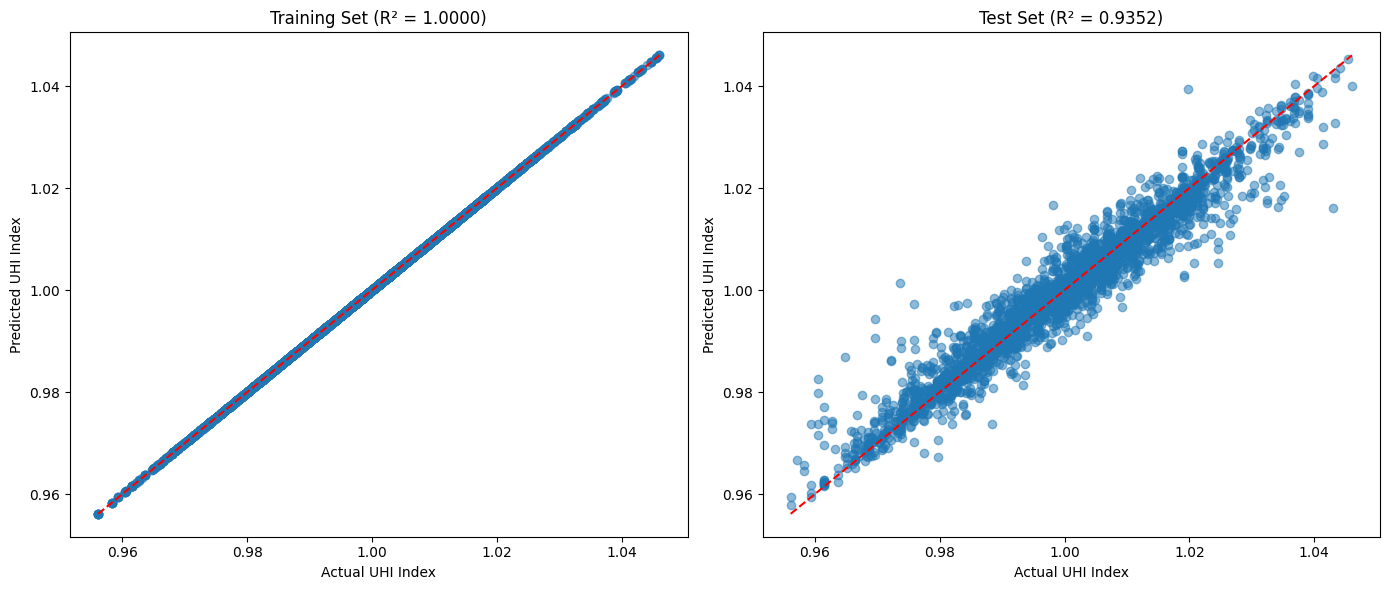

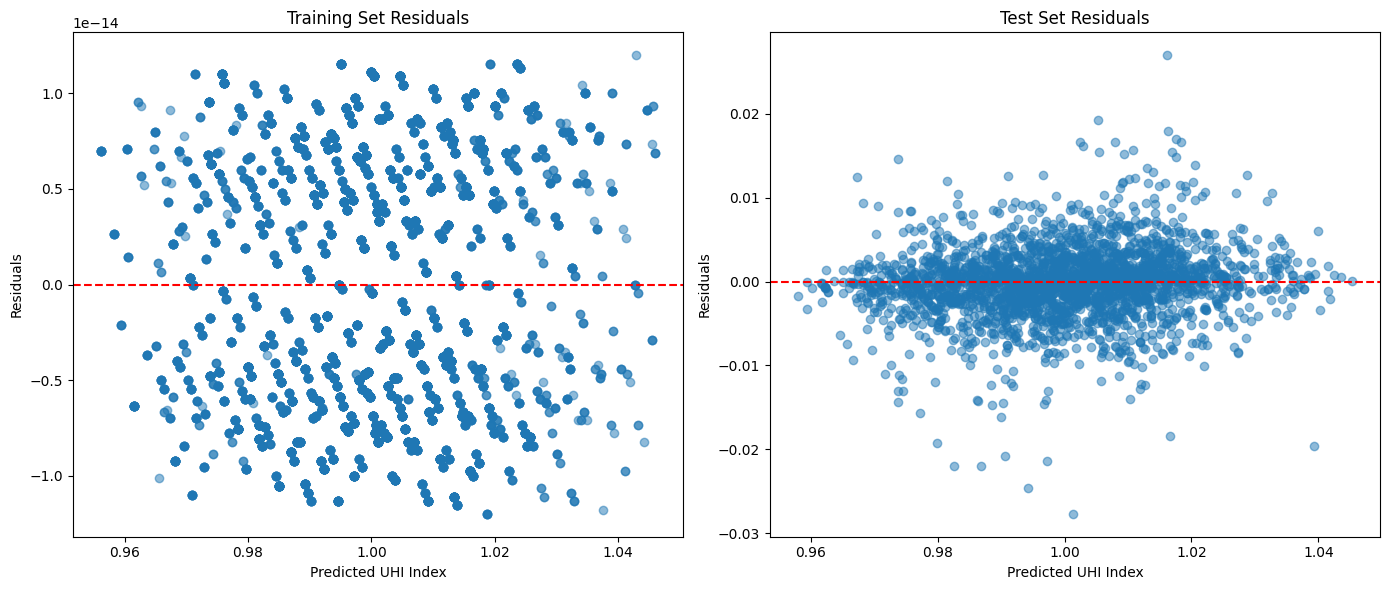

In [32]:
import joblib
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 1. Load the saved models and transformers
model = joblib.load('models/final_model.pkl')  # Random Forest with Interactions
scaler = joblib.load('models/scaler.pkl')
poly = joblib.load('models/poly_features.pkl')

# 2. Load your training and test data
# Replace with your actual data loading code if different
# X_train, X_test, y_train, y_test should be loaded or already in memory from split

# 3. Apply preprocessing to both sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 4. Make predictions on both sets
train_predictions = model.predict(X_train_poly)
test_predictions = model.predict(X_test_poly)

# 5. Evaluate metrics for both sets
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Training Set - R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"Test Set - R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
print(f"Overfitting Gap (Train R² - Test R²): {train_r2 - test_r2:.4f}")

# 6. Optional: Visualize predictions vs actuals for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training set plot
ax1.scatter(y_train, train_predictions, alpha=0.5)
ax1.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
ax1.set_xlabel('Actual UHI Index')
ax1.set_ylabel('Predicted UHI Index')
ax1.set_title(f'Training Set (R² = {train_r2:.4f})')

# Test set plot
ax2.scatter(y_test, test_predictions, alpha=0.5)
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
ax2.set_xlabel('Actual UHI Index')
ax2.set_ylabel('Predicted UHI Index')
ax2.set_title(f'Test Set (R² = {test_r2:.4f})')

plt.tight_layout()
plt.savefig('results/train_test_predictions.png')
plt.show()

# 7. Optional: Create a residual plot for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training residuals
train_residuals = y_train - train_predictions
ax1.scatter(train_predictions, train_residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted UHI Index')
ax1.set_ylabel('Residuals')
ax1.set_title('Training Set Residuals')

# Test residuals
test_residuals = y_test - test_predictions
ax2.scatter(test_predictions, test_residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted UHI Index')
ax2.set_ylabel('Residuals')
ax2.set_title('Test Set Residuals')

plt.tight_layout()
plt.savefig('results/train_test_residuals.png')
plt.show()

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [33]:
#Reading the coordinates for the submission
test_file = pd.read_csv('../Submission_template_UHI2025-v2.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [34]:
# Mapping satellite data for submission.
val_data = map_satellite_data_with_buffer('../data/S2_sample.tiff', '../Submission_template_UHI2025-v2.csv', buffer_radius=700)

Mapping values:   0%|          | 0/1040 [00:00<?, ?it/s]

Mapping values: 100%|██████████| 1040/1040 [00:10<00:00, 98.99it/s] 


In [35]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  

In [36]:
val_data['NBDI'] = (val_data['B11'] - val_data['B08']) / (val_data['B11'] + val_data['B08'])
val_data['NBDI'] = val_data['NBDI'].replace([np.inf, -np.inf], np.nan)

In [37]:
val_data['NDWI'] = (val_data['B03'] - val_data['B08']) / (val_data['B03'] + val_data['B08'])
val_data['NDWI'] = val_data['NDWI'].replace([np.inf, -np.inf], np.nan)

val_data['EVI'] = 2.5 * (val_data['B08'] - val_data['B04']) / (val_data['B08'] + 6 * val_data['B04'] - 7.5 * val_data['B02'] + 1)
val_data['EVI'] = val_data['EVI'].replace([np.inf, -np.inf], np.nan)

val_data['SAVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'] + L) * (1 + L)
val_data['SAVI'] = val_data['SAVI'].replace([np.inf, -np.inf], np.nan)

val_data['MSAVI'] = (2 * val_data['B08'] + 1 - np.sqrt((2 * val_data['B08'] + 1) ** 2 - 8 * (val_data['B08'] - val_data['B04']))) / 2
val_data['MSAVI'] = val_data['MSAVI'].replace([np.inf, -np.inf], np.nan)

val_data['WRI'] = (val_data['B03'] + val_data['B04']) / (val_data['B08'] + val_data['B11'])
val_data['WRI'] = val_data['WRI'].replace([np.inf, -np.inf], np.nan)

In [38]:
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,Latitude,Longitude,buffer_radius_m,NDVI,NBDI,NDWI,EVI,SAVI,MSAVI,WRI
0,1044.880505,1075.409874,1191.131985,1233.171535,1425.242308,1839.694920,1992.372406,2005.183829,2064.122357,1837.927991,...,40.788763,-73.971665,700,0.238396,-0.043521,-0.254684,1.440710,0.357539,0.384949,0.630818
1,1063.295908,1098.116568,1214.035452,1261.365056,1450.818253,1843.540623,1988.143043,2000.090939,2056.551356,1856.380147,...,40.788875,-73.971928,700,0.226502,-0.037265,-0.244563,1.385034,0.339701,0.369288,0.641882
2,787.619593,805.756196,910.140571,865.435829,1073.958304,1700.834775,1926.519742,1960.032525,2023.968841,1511.155858,...,40.789080,-73.967080,700,0.387404,-0.129315,-0.365794,2.464251,0.581003,0.558396,0.511518
3,1091.782151,1127.792233,1243.032785,1298.815976,1481.160476,1834.023288,1963.728095,1971.582320,2025.619007,1873.656541,...,40.789082,-73.972550,700,0.205714,-0.025467,-0.226637,1.286816,0.308524,0.341175,0.661038
4,913.368633,937.825408,1049.759058,1051.480713,1254.946269,1800.624927,2003.626553,2025.197684,2092.390555,1695.054056,...,40.787953,-73.969697,700,0.316483,-0.088742,-0.317220,1.870531,0.474648,0.480739,0.564811


In [39]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01','B06','B8A','B12','NDVI','NBDI','NDWI', 'EVI', 'SAVI', 'WRI']]
submission_val_data.head()

,B01,B06,B8A,B12,NDVI,NBDI,NDWI,EVI,SAVI,WRI
0,1044.880505,1839.694920,2064.122357,1511.188187,0.238396,-0.043521,-0.254684,1.440710,0.357539,0.630818
1,1063.295908,1843.540623,2056.551356,1537.102713,0.226502,-0.037265,-0.244563,1.385034,0.339701,0.641882
2,787.619593,1700.834775,2023.968841,1132.238925,0.387404,-0.129315,-0.365794,2.464251,0.581003,0.511518
3,1091.782151,1834.023288,2025.619007,1571.507318,0.205714,-0.025467,-0.226637,1.286816,0.308524,0.661038
4,913.368633,1800.624927,2092.390555,1327.242633,0.316483,-0.088742,-0.317220,1.870531,0.474648,0.564811


In [40]:
scaler = joblib.load('models/scaler.pkl')
poly = joblib.load('models/poly_features.pkl')
model = joblib.load('models/final_model.pkl')

# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = scaler.transform(submission_val_data)
interactions_submission_data = poly.transform(transformed_submission_data)

In [41]:
#Making predictions
final_predictions = model.predict(interactions_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [42]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [43]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.976959
1,-73.971928,40.788875,0.973256
2,-73.967080,40.789080,0.963505
3,-73.972550,40.789082,0.975316
4,-73.969697,40.787953,0.963155


In [44]:
#Dumping the predictions into a csv file.
submission_df.to_csv("../submissions/submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.